In [3]:
import os
import random
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")



import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import Flatten,Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image 
from keras.layers.normalization import BatchNormalization
from keras import optimizers


Using TensorFlow backend.


In [2]:
driver_details = pd.read_csv('/home/jupyter/driver_imgs_list.csv',na_values='na')
print(driver_details.head(5))


  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [3]:
## Getting all the images

train_image = []
image_label = []


for i in range(10):
    print('now we are in the folder C',i)
    imgs = os.listdir("/home/jupyter/TrainImages/train/c"+str(i))
    for j in range(len(imgs)):
    #for j in range(100):
        img_name = "/home/jupyter/TrainImages/train/c"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        #img = color.rgb2gray(img)
        img = img[50:,120:-50]
        img = cv2.resize(img,(224,224))
        label = i
        driver = driver_details[driver_details['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)



now we are in the folder C 0
now we are in the folder C 1
now we are in the folder C 2
now we are in the folder C 3
now we are in the folder C 4
now we are in the folder C 5
now we are in the folder C 6
now we are in the folder C 7
now we are in the folder C 8
now we are in the folder C 9


In [4]:
## Randomly shuffling the images

import random
random.shuffle(train_image)

In [5]:
# ## getting list of driver names

# D = []
# for features,labels,drivers in train_image:
#     D.append(drivers)

# ## Deduplicating drivers

# deduped = []

# for i in D:
#     if i not in deduped:
#         deduped.append(i)
    

# ## selecting random drivers for the validation set
# driv_selected = []
# import random
# driv_nums = random.sample(range(len(deduped)), 4)
# for i in driv_nums:
#     driv_selected.append(deduped[i])


In [5]:
driv_selected = ['p050', 'p015', 'p022', 'p056']

In [6]:
## Splitting the train and test

X_train= []
y_train = []
X_test = []
y_test = []
D_train = []
D_test = []

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
        D_test.append(drivers)
    
    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)
    
print (len(X_train),len(X_test))
print (len(y_train),len(y_test))

18732 3692
18732 3692


In [7]:
## Converting images to nparray. Encoding the Y

X_train = np.array(X_train).reshape(-1,224,224,3)
X_test = np.array(X_test).reshape(-1,224,224,3)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


print (X_train.shape)


(18732, 224, 224, 3)


In [6]:
## Defining the input

from keras.layers import Input
xception_input = Input(shape = (224, 224, 3), name = 'Image_input')

## The RESNET model

from keras.applications.xception import preprocess_input, decode_predictions
from keras.applications.xception import Xception


#Get the RESNET weights and layers

model_xception_conv = Xception(weights= 'imagenet', include_top=False, input_shape= (224,224,3))
#model_xception_conv.summary()

In [7]:
#Use the generated model 
from keras.models import Model


output_xception_conv = model_xception_conv(xception_input)

#Add the fully-connected layers 

x = Flatten(name='flatten')(output_xception_conv)
# x = Dense(4096, activation='relu', name='fc1')(x)
# x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)


xception_pretrained = Model(input = xception_input, output = x)
# for layer in resnet50_pretrained.layers[:2]:
#     layer.trainable=False
# for layer in resnet50_pretrained.layers[2:]:
#     layer.trainable=True


xception_pretrained.summary()


# Compile CNN model
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0)
sgd = optimizers.SGD(lr = 0.001)
xception_pretrained.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     (None, 224, 224, 3)       0         
_________________________________________________________________
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
predictions (Dense)          (None, 10)                1003530   
Total params: 21,865,010
Trainable params: 21,810,482
Non-trainable params: 54,528
_________________________________________________________________


In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpointer = ModelCheckpoint('xception_weights_aug_alltrained_setval_sgd3.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)


datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# Fits the model on batches with real-time data augmentation:
xception_model = xception_pretrained.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper],
                                                            epochs = 25, verbose = 1, validation_data = (X_test, y_test))



Epoch 1/25
293/292 [==============================] - 249s 851ms/step - loss: 2.2134 - accuracy: 0.1936 - val_loss: 1.9337 - val_accuracy: 0.3475

Epoch 00001: val_loss improved from inf to 1.93373, saving model to xception_weights_aug_alltrained_setval_sgd3.hdf5
Epoch 2/25
293/292 [==============================] - 242s 824ms/step - loss: 1.9692 - accuracy: 0.3076 - val_loss: 1.7060 - val_accuracy: 0.4339

Epoch 00002: val_loss improved from 1.93373 to 1.70605, saving model to xception_weights_aug_alltrained_setval_sgd3.hdf5
Epoch 3/25
293/292 [==============================] - 241s 824ms/step - loss: 1.7542 - accuracy: 0.3954 - val_loss: 1.5214 - val_accuracy: 0.4686

Epoch 00003: val_loss improved from 1.70605 to 1.52141, saving model to xception_weights_aug_alltrained_setval_sgd3.hdf5
Epoch 4/25
293/292 [==============================] - 241s 824ms/step - loss: 1.5828 - accuracy: 0.4561 - val_loss: 1.3126 - val_accuracy: 0.5620

Epoch 00004: val_loss improved from 1.52141 to 1.312

In [11]:
xception_model = xception_pretrained.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper],
                                                            epochs = 10, verbose = 1, validation_data = (X_test, y_test))


Epoch 1/10
293/292 [==============================] - 242s 826ms/step - loss: 0.5773 - accuracy: 0.8042 - val_loss: 0.5807 - val_accuracy: 0.8172

Epoch 00001: val_loss improved from 0.58162 to 0.58072, saving model to xception_weights_aug_alltrained_setval_sgd3.hdf5
Epoch 2/10
293/292 [==============================] - 241s 824ms/step - loss: 0.5602 - accuracy: 0.8094 - val_loss: 0.5794 - val_accuracy: 0.8231

Epoch 00002: val_loss improved from 0.58072 to 0.57939, saving model to xception_weights_aug_alltrained_setval_sgd3.hdf5
Epoch 3/10
293/292 [==============================] - 241s 824ms/step - loss: 0.5544 - accuracy: 0.8114 - val_loss: 0.5800 - val_accuracy: 0.8191

Epoch 00003: val_loss did not improve from 0.57939
Epoch 4/10
293/292 [==============================] - 242s 825ms/step - loss: 0.5331 - accuracy: 0.8211 - val_loss: 0.6055 - val_accuracy: 0.8142

Epoch 00004: val_loss did not improve from 0.57939
Epoch 5/10
293/292 [==============================] - 241s 824ms/ste

In [13]:
xception_model = xception_pretrained.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper],
                                                            epochs = 10, verbose = 1, validation_data = (X_test, y_test))


Epoch 1/10
293/292 [==============================] - 242s 827ms/step - loss: 0.4771 - accuracy: 0.8421 - val_loss: 0.5967 - val_accuracy: 0.8242

Epoch 00001: val_loss did not improve from 0.56783
Epoch 2/10
293/292 [==============================] - 241s 824ms/step - loss: 0.4666 - accuracy: 0.8431 - val_loss: 0.5516 - val_accuracy: 0.8283

Epoch 00002: val_loss improved from 0.56783 to 0.55156, saving model to xception_weights_aug_alltrained_setval_sgd3.hdf5
Epoch 3/10
293/292 [==============================] - 242s 825ms/step - loss: 0.4519 - accuracy: 0.8480 - val_loss: 0.5783 - val_accuracy: 0.8250

Epoch 00003: val_loss did not improve from 0.55156
Epoch 4/10
293/292 [==============================] - 242s 824ms/step - loss: 0.4611 - accuracy: 0.8461 - val_loss: 0.5590 - val_accuracy: 0.8369

Epoch 00004: val_loss did not improve from 0.55156
Epoch 5/10
293/292 [==============================] - 242s 825ms/step - loss: 0.4563 - accuracy: 0.8443 - val_loss: 0.5875 - val_accuracy:

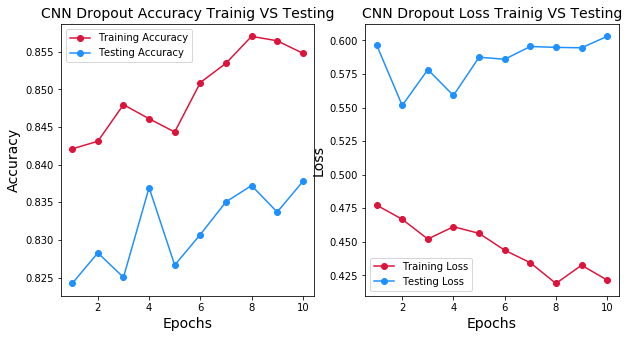

In [14]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(xception_pretrained.history.history['accuracy']) + 1), xception_pretrained.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(xception_pretrained.history.history['val_accuracy']) + 1), xception_pretrained.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(xception_pretrained.history.history['loss']) + 1), xception_pretrained.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(xception_pretrained.history.history['val_loss']) + 1), xception_pretrained.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

Image number: 0
Image number: 1
Image number: 2
Image number: 3
Image number: 4
Image number: 5
Image number: 6
Image number: 7
Image number: 8
Image number: 9
Image number: 10
Image number: 11
Image number: 12
Image number: 13
Image number: 14
Image number: 15
Image number: 16
Image number: 17
Image number: 18
Image number: 19


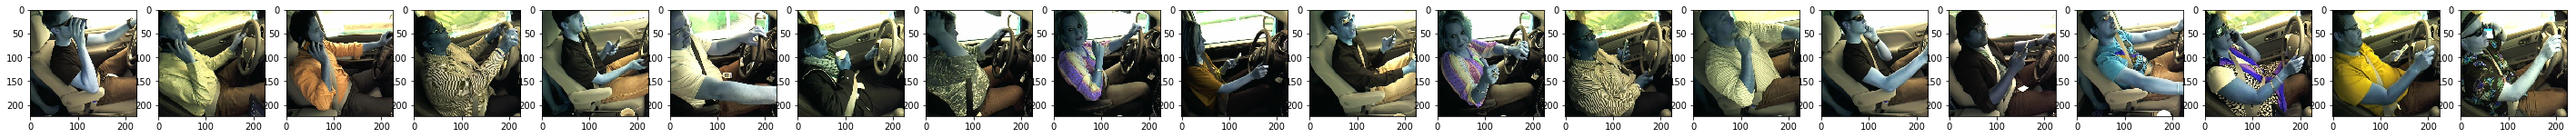

In [4]:
# labels is the image array
test_image = []
i = 0
fig, ax = plt.subplots(1, 20, figsize = (50,50 ))

files = os.listdir('/home/jupyter/TestImages')
nums = np.random.randint(low=1, high=len(files), size=20)
for i in range(20):
    print ('Image number:',i)
    img = cv2.imread('/home/jupyter/TestImages/'+files[nums[i]])
    #img = color.rgb2gray(img)
    img = img[50:,120:-50]
    img = cv2.resize(img,(224,224))
    test_image.append(img)
    ax[i].imshow(img,cmap = 'gray')
    plt.show


In [8]:
test = []

for img in test_image:
    test.append(img)
    
xception_pretrained.load_weights('xception_weights_aug_alltrained_setval_sgd3.hdf5')


test = np.array(test).reshape(-1,224,224,3)
prediction = xception_pretrained.predict(test)

In [9]:
prediction[0]

array([4.1459408e-03, 1.8657466e-04, 2.9767808e-02, 5.8343371e-06,
       2.0622686e-03, 4.0489369e-05, 3.0284923e-01, 2.5818619e-04,
       6.5633804e-01, 4.3456117e-03], dtype=float32)

In [10]:
tags = { "C0": "safe driving",
"C1": "texting - right",
"C2": "talking on the phone - right",
"C3": "texting - left",
"C4": "talking on the phone - left",
"C5": "operating the radio",
"C6": "drinking",
"C7": "reaching behind",
"C8": "hair and makeup",
"C9": "talking to passenger" }

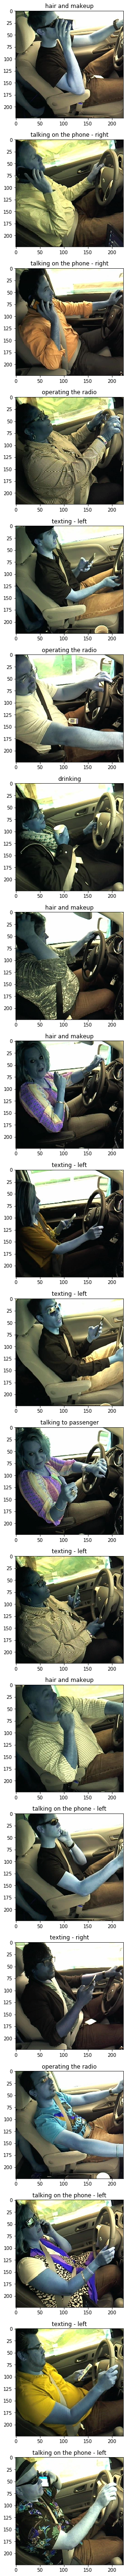

In [11]:
# labels is the image array
i = 0
fig, ax = plt.subplots(20, 1, figsize = (100,100))

for i in range(20):
    ax[i].imshow(test[i].squeeze())
    predicted_class = 'C'+str(np.where(prediction[i] == np.amax(prediction[i]))[0][0])
    ax[i].set_title(tags[predicted_class])
    plt.show
    


In [1]:
print(2)

2
